# Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import joblib
from imblearn.over_sampling import SMOTE


In [2]:
mhs = pd.read_csv('../MHS.csv')
mhs = mhs.drop(columns=['pembimbing_tugas_akhir'])

sa = pd.read_csv('../SA.csv')
krs = pd.read_csv('../KRS.csv')

point_mapping = {
    'Lokal': 1,
    'Provinsi': 3,
    'Nasional': 5,
    'International': 10
}

# Apply mapping
sa['points'] = sa['tingkat_kegiatan'].str.lower().map(point_mapping).fillna(1)

# Calculate total points for each student
sa_points = sa.groupby('npm_mahasiswa')['points'].sum().reset_index()
sa_points.rename(columns={'points': 'total_activity_points'}, inplace=True)

# Calculate attendance percentage per course
krs['attendance_percentage'] = (krs['total_hadir'] / krs['total_pertemuan']) * 100

total_sks = krs.groupby('npm_mahasiswa')['sks_matakuliah'].sum().reset_index()
total_sks.rename(columns={'sks_matakuliah': 'total_sks'}, inplace=True)

attendance = krs.groupby('npm_mahasiswa')['attendance_percentage'].mean().reset_index()
attendance.rename(columns={'attendance_percentage': 'attendance_rate'}, inplace=True)

In [3]:
# Merge SA and KRS aggregated data with MHS.csv

data = mhs.merge(sa_points, on='npm_mahasiswa', how='left')
data = data.merge(total_sks, on='npm_mahasiswa', how='left')
data = data.merge(attendance, on='npm_mahasiswa', how='left')

data.fillna(0, inplace=True)

# Fill missing values (e.g., students with no activities or KRS data)
data['attendance_rate'] = data['attendance_rate'].fillna(0)
data['ipk_mahasiswa'] = data['ipk_mahasiswa'].fillna(0)

data.dropna(inplace=True)

# data['attendance_rate'] = data['total_hadir'] / data['total_pertemuan']
data['activity_count'] = sa.groupby('npm_mahasiswa')['nama_kegiatan'].transform('count')
data['activity_count'] = data['activity_count'].fillna(0)


In [4]:
data.head()

,npm_mahasiswa,nama_mahasiswa,prodi_mahasiswa,angkatan_mahasiswa,ipk_mahasiswa,status_mahasiswa,total_activity_points,total_sks,attendance_rate,activity_count,years_in_uni
0,1931173,Celine Te,Sistem Informasi,2019,3.87,Lulus,18.0,145.0,94.841270,23,5
1,1931001,Rido Renando,Sistem Informasi,2019,3.72,Lulus,26.0,145.0,96.428571,61,5
2,1931009,Richie Marlon,Sistem Informasi,2019,3.90,Lulus,15.0,145.0,88.571429,61,5
3,1931083,Elvin Whang,Sistem Informasi,2019,3.68,Lulus,9.0,145.0,93.831169,53,5
4,2031001,Robin Sunjaya,Sistem Informasi,2020,3.88,Aktif,31.0,149.0,90.527950,53,4


# Preprocessing


In [5]:
# X = data[['ipk_mahasiswa', 'attendance_rate', 'total_activity_points','activity_count']]
X = data[['ipk_mahasiswa', 'attendance_rate', 'total_activity_points','activity_count','angkatan_mahasiswa']]
y = (data['status_mahasiswa'].isin(['Drop-out (putus studi)', 'Keluar'])).astype(int)

print(y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

status_mahasiswa
0    640
1     33
Name: count, dtype: int64


# Train Model

In [8]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Train the model on the resampled data
model = RandomForestClassifier(
    random_state=42,
    n_jobs=3,
    class_weight={1: 5},
)
model.fit(X_resampled, y_resampled)

# model = RandomForestClassifier(
#     random_state=42,
#     n_jobs=3,
#     class_weight='balanced',
# )
# model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=3, random_state=42)

RandomForestClassifier(class_weight='balanced', n_jobs=3, random_state=42)

# Evaluate Model

Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       128
           1       0.57      0.57      0.57         7

    accuracy                           0.96       135
   macro avg       0.77      0.77      0.77       135
weighted avg       0.96      0.96      0.96       135

ROC-AUC: 0.53


D:\Projects\test-profiler-ml\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


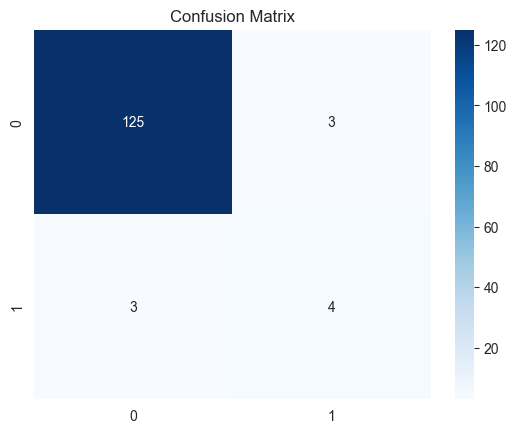

In [9]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification Report
print(classification_report(y_test, y_pred))

# ROC-AUC (only for models that output probabilities)
if hasattr(model, "predict_proba"):
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])
    print(f"ROC-AUC: {roc_auc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Visualize Feature Importance

In [ ]:
# Plot feature importance
importances = model.feature_importances_
feature_names = X.columns
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importance')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    verbose=2,
    n_jobs=3,
)

grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Handle Imbalance

In [ ]:
print(X.isnull().sum())

In [ ]:
model = RandomForestClassifier(class_weight='balanced', random_state=42)

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)